# Airline Passenger data

## Loading and plotting the data


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/home/xu/Dataset/international-airline-passengers.csv', 
                   usecols = [1], 
                   engine = 'python', 
                   skipfooter = 3)

In [2]:
data.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


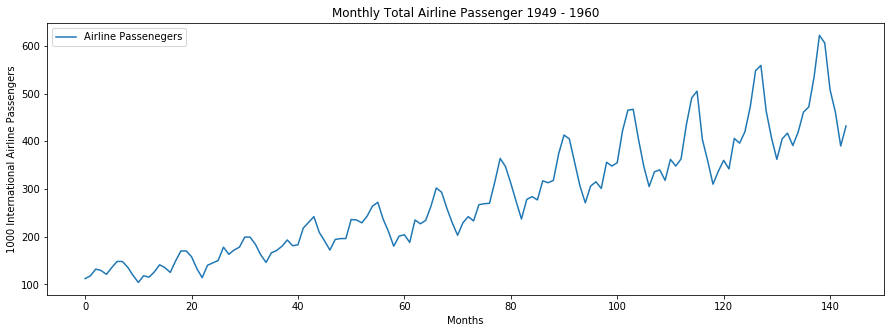

In [3]:
plt.figure(figsize = (15, 5))
plt.plot(data, label = 'Airline Passenegers')
plt.xlabel('Months')
plt.ylabel('1000 International Airline Passengers')
plt.title('Monthly Total Airline Passenger 1949 - 1960')
plt.legend()
plt.show()

## Building the LSTM model

In [5]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

### Data Preparation

In [7]:
# Get raw data from dataframe
data_raw = data.values.astype('float32')

# Normalization
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

### Split into testing/training data

In [9]:
Train_scale = 0.6
train_size = int(len(dataset) * Train_scale)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset),:]
print('Training set:',train_size,'\nTesting set:',test_size)

Training set: 86 
Testing set: 58


### Prepare data for Keras

In [10]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i+window_size, 0])
    return (np.array(data_X), np.array(data_Y))

In [11]:
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print('Original Training dataset shape:',train_X.shape)

Training dataset shape: (84, 1)


In [13]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print('New Training dataset shape:',train_X.shape)

New Training dataset shape: (84, 1, 1)


### Build simple LSTM model on training data

In [14]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    model.add(LSTM(4, input_shape= (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.fit(train_X, train_Y, epochs = 100, batch_size = 1, verbose = 2)
    return model

In [16]:
model = fit_model(train_X, train_Y, window_size)

Epoch 1/100
 - 1s - loss: 0.0424
Epoch 2/100
 - 0s - loss: 0.0216
Epoch 3/100
 - 0s - loss: 0.0160
Epoch 4/100
 - 0s - loss: 0.0148
Epoch 5/100
 - 0s - loss: 0.0141
Epoch 6/100
 - 0s - loss: 0.0136
Epoch 7/100
 - 0s - loss: 0.0132
Epoch 8/100
 - 0s - loss: 0.0127
Epoch 9/100
 - 0s - loss: 0.0122
Epoch 10/100
 - 0s - loss: 0.0118
Epoch 11/100
 - 0s - loss: 0.0114
Epoch 12/100
 - 0s - loss: 0.0109
Epoch 13/100
 - 0s - loss: 0.0105
Epoch 14/100
 - 0s - loss: 0.0100
Epoch 15/100
 - 0s - loss: 0.0096
Epoch 16/100
 - 0s - loss: 0.0091
Epoch 17/100
 - 0s - loss: 0.0086
Epoch 18/100
 - 0s - loss: 0.0080
Epoch 19/100
 - 0s - loss: 0.0074
Epoch 20/100
 - 0s - loss: 0.0069
Epoch 21/100
 - 0s - loss: 0.0064
Epoch 22/100
 - 0s - loss: 0.0058
Epoch 23/100
 - 0s - loss: 0.0053
Epoch 24/100
 - 0s - loss: 0.0048
Epoch 25/100
 - 0s - loss: 0.0043
Epoch 26/100
 - 0s - loss: 0.0039
Epoch 27/100
 - 0s - loss: 0.0035
Epoch 28/100
 - 0s - loss: 0.0032
Epoch 29/100
 - 0s - loss: 0.0029
Epoch 30/100
 - 0s - lo

## Results

### Prediction adn model evaluation

In [17]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return score, pred

In [18]:
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)

rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print('Training data score: {:.2f} RMSE'.format(rmse_train))
print('Testing data score: {:.2f} RMSE'.format(rmse_test))

Training data score: 20.83 RMSE
Testing data score: 49.40 RMSE


### Comparision chart

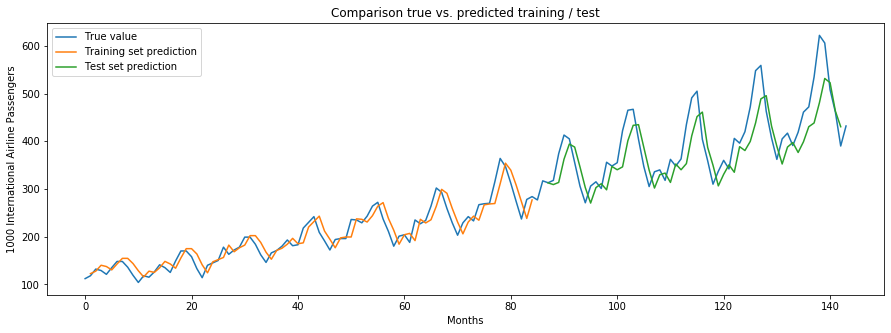

In [20]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict)+window_size,:] = train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + window_size*2 + 1:len(dataset)-1,:] = test_predict

plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()